Ignore this notebook for now, some of the data appears incorrect.

We want to check the effect of a non-heaving spar's width on the 
convergence of slant hydro-coefficients.
The hydro coefficients will change, but accuracy of methods to compute them may not (ideal).

Step 1: Get Capytaine data. Spar radius: 0, 1, 2 (already have data for 3). Outer radius changes accordingly to maintain same slope.

Step 2: Get MEEM data. 
(a) Fix NMK = 200, vary res from 10 to 60 by intervals of 10. 
(b) Fix res = 50, vary NMK from 50 to 300 by intervals of 50.
(c) Do for all heights and spar widths, but pick 1 approximation version.

Step 3: Do all necessary plots with this data.

Step 4: Pick the d1 = 80 config, and complete its data set by varying both NMK and res (50 - 250, 40 - 70). Compare results.

(supplementary code: Step 2 computed with modified ps4-varied-slant-convergence.py)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from numpy import sqrt
import time

import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem
from capytaine_generator import CapytaineSlantSolver
from helpers import *
from plotting_helpers import *

import pickle

In [2]:
# Generate the configurations: Matching most variables with the ps3 stuff.
file1 = "data/ps5.pkl"
file2 = "data/ps5-res-nmk-grid.pkl"

# h = 100
# m0 = 0.9
# rho = 1023
# d1s = list(range(5, 96, 5))

# configurations = []
# # No spar:
# for d1 in d1s:
#   configurations.append({"name" : "config-s0-d" + str(d1),
#                          "h" : h,
#                          "a" : [4],
#                          "d_in" : [d1],
#                          "d_out" : [5], 
#                          "heaving" : [1],
#                          "m0" : m0, 
#                          "rho" : rho})

# # Yes spar (radius of 1, 2)
# for rad in [1, 2]:
#   for d1 in d1s:
#     configurations.append({"name" : "config-s"+str(rad)+"-d" + str(d1),
#                           "h" : h,
#                           "a" : [rad, rad + 4], # this was set to 4 for the data, so that's inaccurate. Will need re-running.
#                           "d_in" : [d1, d1],
#                           "d_out" : [d1, 5], 
#                           "heaving" : [0, 1],
#                           "m0" : m0, 
#                           "rho" : rho})

# After all the code finishes running, run this instead to get all data:
with open(file1, "rb") as f:
  configurations = pickle.load(f)
with open(file2, "rb") as f:
  data_lst = pickle.load(f)

In [3]:
css = CapytaineSlantSolver(False, False, False, False, False)

def compute_cpt_slant(config):
  t_densities = [max(20, int(10 * r)) for r in config["a"]]
  if len(config["a"]) == 1:
    f_densities = [140, 15]
  else:
    f_densities = [15, 140, 15]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 150, config["h"], config["m0"], config["rho"], 1, f_densities)
  am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
  return am, dp

In [4]:
# Data generation (ignore, commented out)
# get the data from ps3/ps4 into here

# def subdictionary(dict0, key_lst):
#   return {k: dict0[k] for k in key_lst if k in dict0}

# with open("data/ps4-all-configs-res-nmk.pkl", "rb") as f:
#   ps4_data = pickle.load(f)

# # eliminate unneeded data
# key_lst = ['name', 'h', 'a', 'd_in', 'd_out', 'heaving', 'm0', 'rho',
#            'CPT slant AM', 'CPT slant DP', 'AMs by res v2', 'DPs by res v2', 'DPs by nmk v2', 'DPs by nmk v2']
# ps4_data = [subdictionary(config, key_lst) for config in ps4_data]

# def rekey(dictionary, old_key, new_key):
#   if old_key in dictionary:
#     dictionary[new_key] = dictionary[old_key]
#     del dictionary[old_key]

# for config in ps4_data:
#   config["name"] = "config-s3-d" + str(config["d_in"][0])
#   rekey(config, "AMs by res v2", "AMs by res")
#   rekey(config, "DPs by res v2", "DPs by res")
#   rekey(config, "AMs by nmk v2", "AMs by nmk")
#   rekey(config, "DPs by nmk v2", "DPs by nmk")
#   configurations.append(config)
  
# for config in configurations:
#   am, dp = compute_cpt_slant(config)
#   config["CPT slant AM"] = am
#   config["CPT slant DP"] = dp
#   update_data_file(configurations, "data/ps5.pkl")
#   print("Finished " + config["name"])

In [5]:
# Additional plotting helper functions
def transpose(matrix):
    return [list(row) for row in zip(*matrix)]

def select(lst_of_lsts, indices):
    return [[lst[i] for i in indices] for lst in lst_of_lsts]

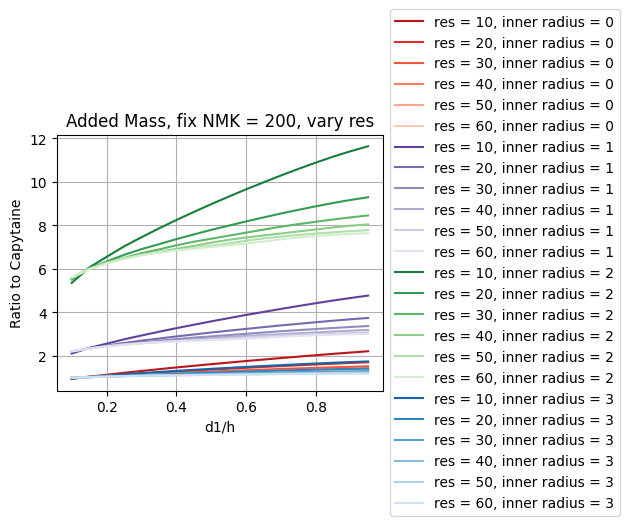

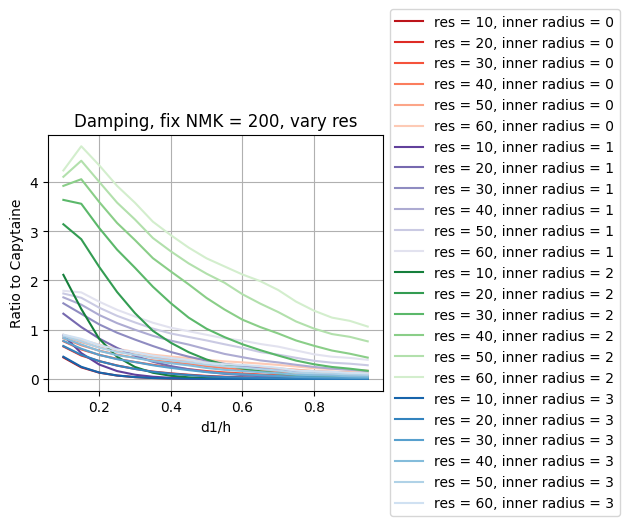

In [25]:
# There is likely some kind of bug in the generation, because the purple and green data looks incorrect.
def plot_type_1(configurations):
  x = [entry/100 for entry in list(range(10, 96, 5))]
  resolutions = [10, 20, 30, 40, 50, 60]
  nmks = [50, 100, 150, 200, 250, 300]
  spar_widths = [0, 1, 2, 3]
  colors = ["Reds", "Purples", "Greens", "Blues"]

  subconfig_lst = [configurations[1:19], configurations[20:38], configurations[39:57], configurations[58:]]
  keys = ["AMs by res", "DPs by res"] #, "AMs by nmk", "DPs by nmk"
  hc_raw = [[extract(subconfigs, key, 6) for key in keys] for subconfigs in subconfig_lst]

  ams_by_res_ratio = [list_ratios(hc_raw[i][0], [config["CPT slant AM"] for config in subconfig_lst[i]]) for i in range(len(spar_widths))]
  dps_by_res_ratio = [list_ratios(hc_raw[i][1], [config["CPT slant DP"] for config in subconfig_lst[i]]) for i in range(len(spar_widths))]
  # ams_by_nmk_ratio = [list_ratios(hc_raw[i][2], [config["CPT slant AM"] for config in subconfig_lst[i][1:]]) for i in range(3)]
  # dps_by_nmk_ratio = [list_ratios(hc_raw[i][3], [config["CPT slant DP"] for config in subconfig_lst[i][1:]]) for i in range(3)]

  res_labs = make_label(resolutions, "res")
  nmk_labs = make_label(nmks, "nmk")
  width_labs = make_label(spar_widths, "inner radius")
  res_lab_lst = []
  nmk_lab_lst = []
  for width_lab in width_labs:
    res_lab_lst.append([(res_lab + ", " + width_lab) for res_lab in res_labs])
    nmk_lab_lst.append([(nmk_lab + ", " + width_lab) for nmk_lab in nmk_labs])

  plot_multiple_fade(x, ams_by_res_ratio, labs = res_lab_lst, title = "Added Mass, fix NMK = 200, vary res",
                    xlab = "d1/h", ylab = "Ratio to Capytaine", colors = colors)
  plot_multiple_fade(x, dps_by_res_ratio, labs = res_lab_lst, title = "Damping, fix NMK = 200, vary res",
                    xlab = "d1/h", ylab = "Ratio to Capytaine", colors = colors)
  # plot_multiple_fade(x, ams_by_nmk_ratio, labs = nmk_lab_lst, title = "Added Mass, fix res = 50, vary NMK",
  #                   xlab = "d1/h", ylab = "Ratio to Capytaine")
  # plot_multiple_fade(x, dps_by_nmk_ratio, labs = nmk_lab_lst, title = "Damping, fix res = 50, vary NMK",
  #                   xlab = "d1/h", ylab = "Ratio to Capytaine")

plot_type_1(configurations)

In [8]:
def solve_prob(config, res, version, nmk):
  x, cs, prob = solve_problem(Problem, config["h"], config["a"], config["d_in"], config["d_out"], config["heaving"],
                              config["m0"], config["rho"], res, version, nmk = nmk)
  return prob, x

In [9]:
# Step 4: (More data generation commented out, ignore)

# data_dict = {}
# d80_configs = [configurations[15], configurations[34], configurations[53]]
# data_lst = []
# for config in d80_configs:
#   data_dict = {}
#   data_lst.append(data_dict)
#   for res in [40, 60]:
#     for nmk in [50, 100, 150, 250, 300]:
#       prob, x = solve_prob(config, res, nmk)
#       am, dp = prob.hydro_coeffs(x, "capytaine")
#       data_dict[str(res) + "-" + str(nmk) + " AM"] = am
#       data_dict[str(res) + "-" + str(nmk) + " DP"] = dp
#       update_data_file(data_lst, file2)
#   for res in [70]:
#     for nmk in [50, 100, 150, 200, 250, 300]:
#       prob, x = solve_prob(config, res, nmk)
#       am, dp = prob.hydro_coeffs(x, "capytaine")
#       data_dict[str(res) + "-" + str(nmk) + " AM"] = am
#       data_dict[str(res) + "-" + str(nmk) + " DP"] = dp
#       update_data_file(data_lst, file2)

# Populate additional terms from ps5
# d80_configs = [configurations[15], configurations[34], configurations[53]]

# for j in range(3):
#   # get the res = 50 data
#   res = 50
#   nmks = [50, 100, 150, 200, 250, 300]
#   for i in range(6):
#     data_lst[j][str(res) + "-" + str(nmks[i]) + " AM"] = d80_configs[j]["AMs by nmk"][i]
#     data_lst[j][str(res) + "-" + str(nmks[i]) + " DP"] = d80_configs[j]["DPs by nmk"][i]

#   # get the nmk = 200 data
#   nmk = 200
#   data_lst[j][str(40) + "-" + str(nmk) + " AM"] = d80_configs[j]["AMs by res"][3] # res = 40
#   data_lst[j][str(40) + "-" + str(nmk) + " DP"] = d80_configs[j]["DPs by res"][3]
#   data_lst[j][str(60) + "-" + str(nmk) + " AM"] = d80_configs[j]["AMs by res"][5] # res = 60
#   data_lst[j][str(60) + "-" + str(nmk) + " DP"] = d80_configs[j]["DPs by res"][5]
#   update_data_file(data_lst, file2)

# # And for completeness, add all that data from ps4
# with open("data/ps4-res-nmk-grid.pkl", "rb") as f:
#   ps4_data = pickle.load(f)
# data_lst.append(ps4_data)
# update_data_file(data_lst, file2)

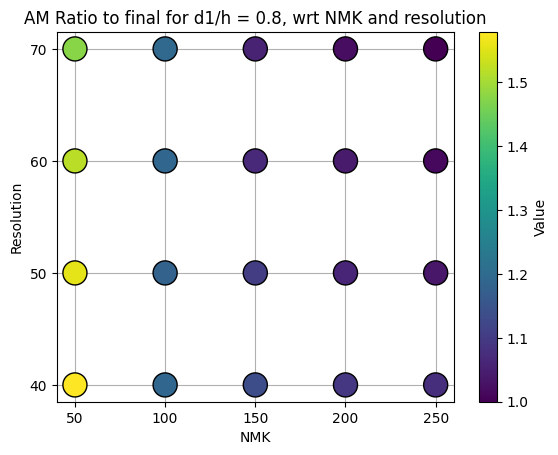

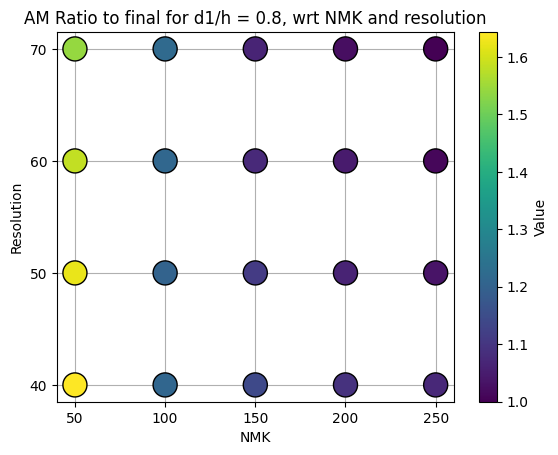

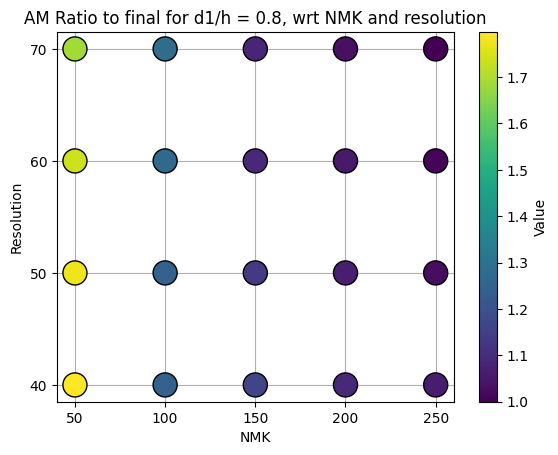

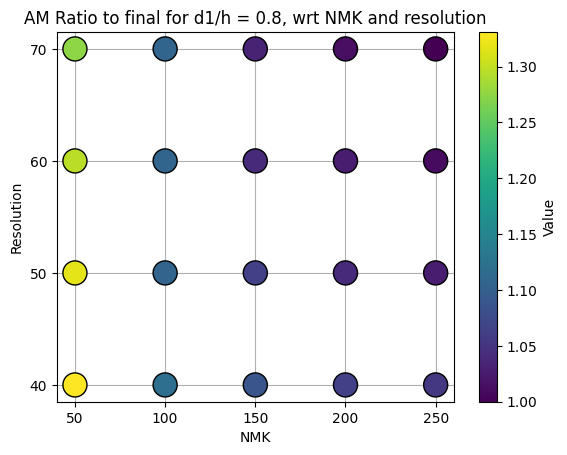

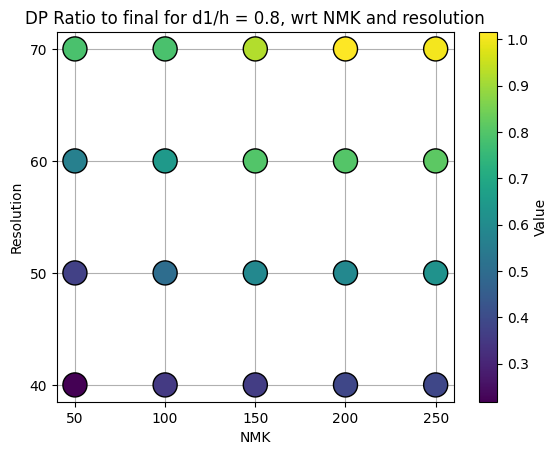

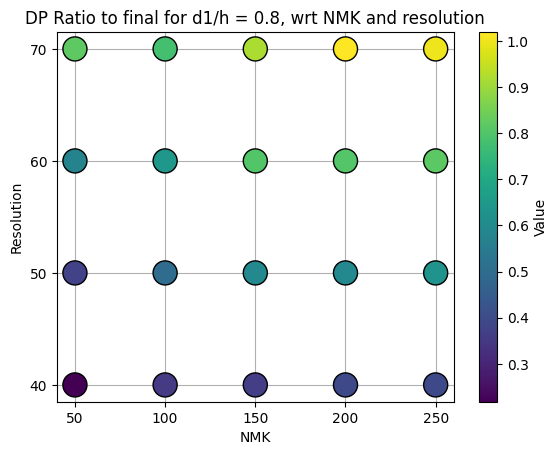

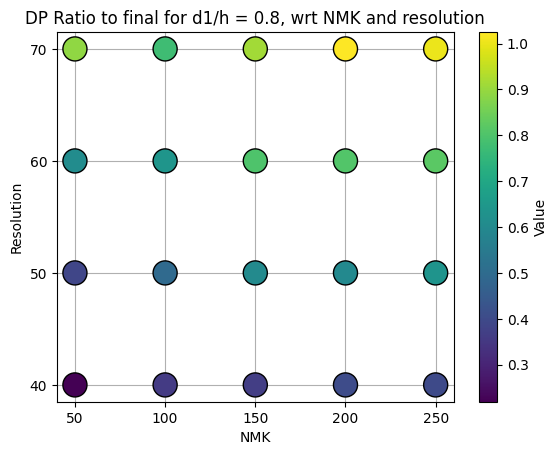

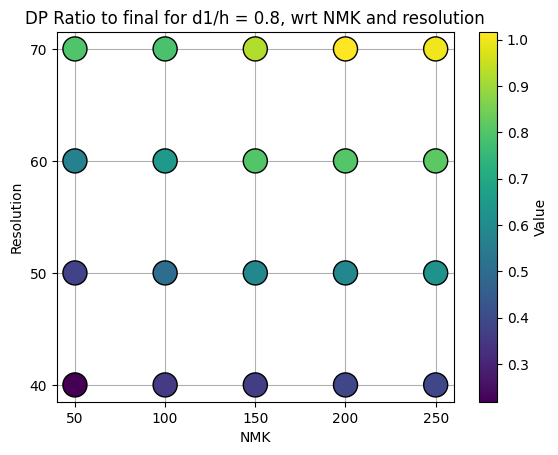

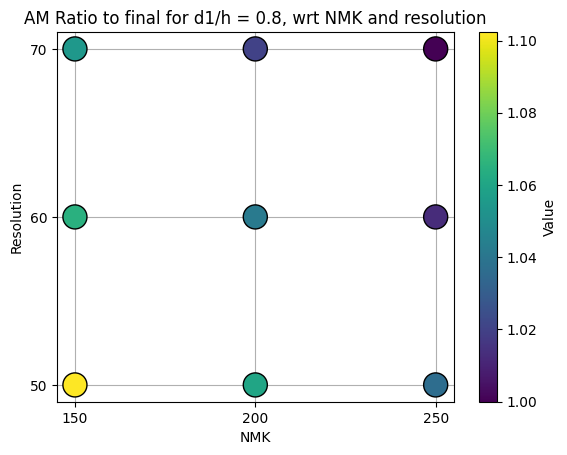

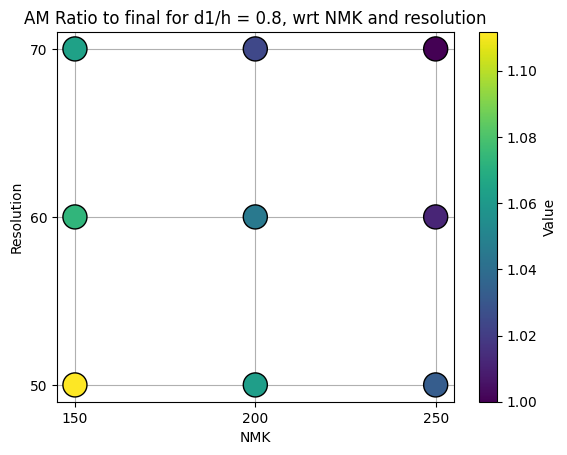

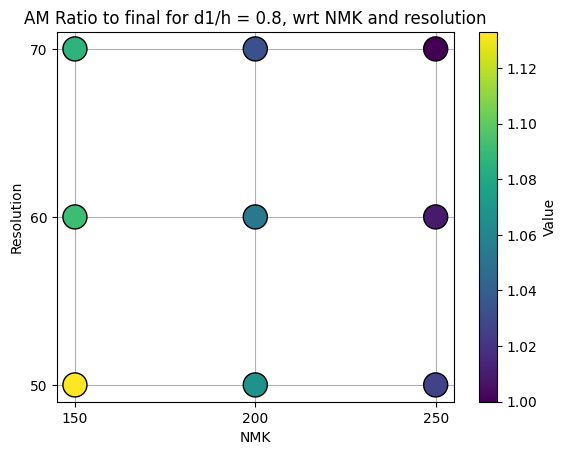

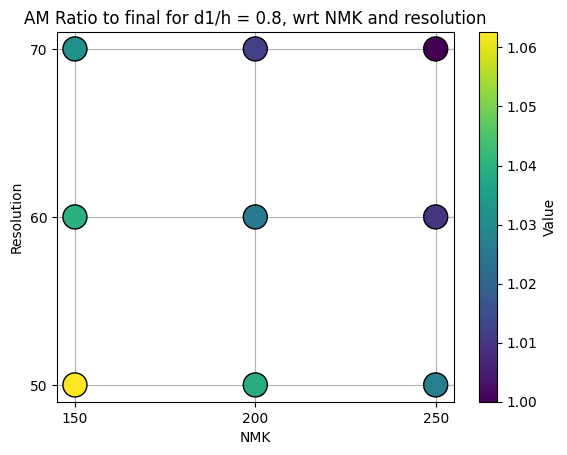

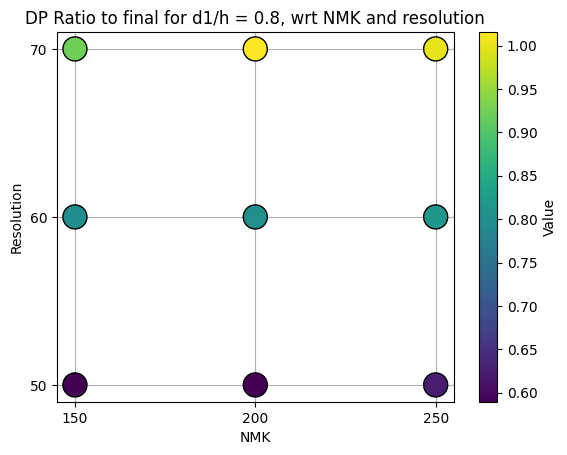

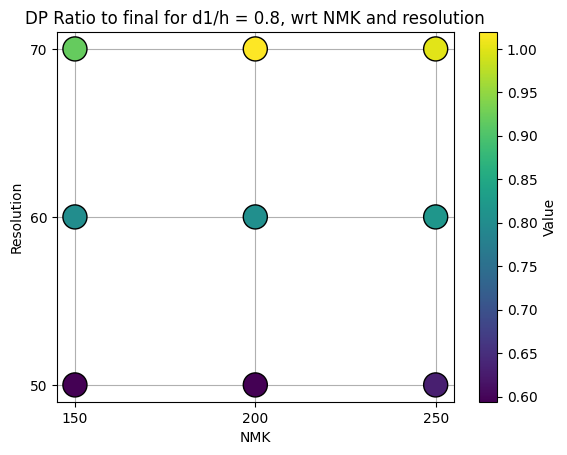

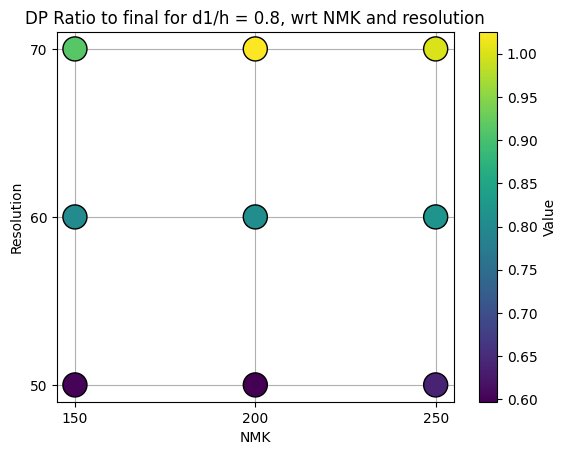

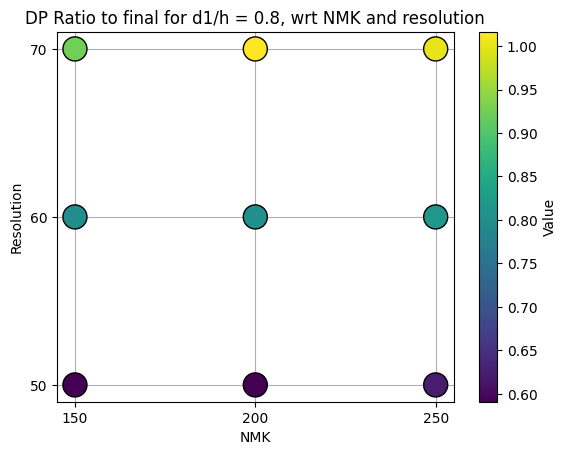

In [10]:
def plot_res_nmk_grid(coeff, data_dict, resolutions, nmks):

  data = [[data_dict[str(res) + "-" + str(nmk) + " " + coeff] for nmk in nmks] for res in resolutions]

  # Axis values
  x_vals = np.array(nmks)
  y_vals = np.array(resolutions)

  values = np.array(data)/(data[-1][-1]) # scale it
  

  # Create coordinate grid
  X, Y = np.meshgrid(x_vals, y_vals)

  # Flatten everything
  x_flat = X.flatten()
  y_flat = Y.flatten()
  val_flat = values.flatten()

  plt.grid(True, zorder=0)
  # Plot
  plt.scatter(x_flat, y_flat, c=val_flat, s=300, cmap='viridis', edgecolors='black', zorder=2)

  plt.colorbar(label='Value')
  plt.xlabel("NMK")
  plt.ylabel("Resolution")
  plt.title(coeff + " Ratio to final for d1/h = 0.8, wrt NMK and resolution")
  plt.xticks(x_vals)
  plt.yticks(y_vals)
  plt.show()

def plot_all_res_nmk_grid(coeff, data_lst, resolutions, nmks):
  for data_dict in data_lst:
    plot_res_nmk_grid(coeff, data_dict, resolutions, nmks)

resolutions = [40, 50, 60, 70]
nmks = [50, 100, 150, 200, 250] # [50, 100, 150, 200, 250, 300] 


plot_all_res_nmk_grid("AM", data_lst, resolutions, nmks)
plot_all_res_nmk_grid("DP", data_lst, resolutions, nmks)
plot_all_res_nmk_grid("AM", data_lst, resolutions[1:], nmks[2:]) # Possibly more informative scaling.
plot_all_res_nmk_grid("DP", data_lst, resolutions[1:], nmks[2:])